# Welcome to this kernel

This is a simple kernel that documented my journey with the Titanic Dataset.

<a id = "toc"></a>
# Table of contents

[Installing new libraries](#new_libraries)

[Imports of the main libraries](#imports)

[Global variables](#global_variables)

[Helper functions and classes](#helpers)

[Data loading](#data_load)

[Train test split](#train_test_split)

[Exploratory data analysis (EDA)](#eda)

[Feature engineering](#fe)

[KFold model training](#model_training)

[Test data preparation and predict](#test_data_prep_pred)

[Kaggle submission](#kaggle_sub)

[CV vs Kaggle LB](#cv_vs_kaggle_lb)

<a id = "new_libraries"></a>
# Installing new libraries
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [1]:
pass

<a id = "imports"></a>
# Imports of the main libraries
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import TransformerMixin, BaseEstimator, clone

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id = "global_variables"></a>
# Global variables
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [3]:
SEED = 42
FOLDS = 4

PATH_TRAIN = "../input/titanic/train.csv"
PATH_TEST = "../input/titanic/test.csv"

<a id = "helpers"></a>
# Helper functions and classes
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [4]:
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------
class DataLoader(object):
    '''
    Helper class that allows you to load train and test data
    '''
    def __init__(self, path_train, path_test, drop_columns = None, shuffle = True):
        '''
        Constructor for the class. 
        Needs the path for train and test data.
        '''        
        self.path_train = path_train
        self.path_test = path_test
        self.drop_columns = drop_columns
        self.shuffle = shuffle
        
    def load_data(self):
        '''
        Loads train and test and retuns a tupple with the data
        '''
        train = pd.read_csv(self.path_train)
        train.set_index("PassengerId", inplace = True)
        
        test = pd.read_csv(self.path_test)
        test.set_index("PassengerId", inplace = True)
        
        if self.shuffle: 
            train = train.sample(frac = 1, random_state = SEED)
            test = test.sample(frac = 1, random_state = SEED)
        
        if self.drop_columns != None:
            train.drop(self.drop_columns, inplace = True, axis = 1)
            test.drop(self.drop_columns, inplace = True, axis = 1)
        
        return train, test
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------

class NumpyToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Class that helps you convert a Numpy Array into a pandas DataFrame inside sklearn pipelines
    '''
    def __init__(self, columns, index = None):
        '''
        Constructor for the class.
        Expects index and columns as parameters.
        '''
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        if self.index != None:
            X = pd.DataFrame(X, index = self.index, columns = self.columns)
            
        else:
            X = pd.DataFrame(X, columns = self.columns)
            
        return X
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------    
class FeatureGenerator(BaseEstimator, TransformerMixin):
    '''
    Class that generates features and works with sklearn pipeline
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X["AgeQcut"] = X.apply(create_partition, axis = 1)
        X["PclassSex"] = X.apply(lambda row: str.title(row["Sex"]) + " " + str(row["Pclass"]), axis = 1)
        X["NameLen"] = X["Name"].apply(lambda name: (len(name.split(" "))))
        
        return X
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------    
cleaning_dict = {
    'Mr': 'Mr',
    'Don': "Mr",
    
    'Miss': 'Miss',
    'Ms': "Miss",
    'Mme': "Miss",
    'Lady': "Miss",
    'Dona': "Miss",
    
    'Mrs': 'Mrs',
    'Mlle': "Mrs",
    
    'Master': "Master",
    
    'Rev': "Other",
    'Dr': "Other",
    'Col': "Other",
    'Major': "Other",
    'Sir': "Other",
    'Capt': "Other",
    'Jonkheer': "Other",
    'the Countess': "Other"
}

class TitleExtractor(BaseEstimator, TransformerMixin):
    '''
    Class that will allow us to extract useful features from the Names column
    '''
    def __init__(self, cleaning_dict):
        self.cleaning_dict = cleaning_dict
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X["NameSplitted"] = X["Name"].str.split(",")
        X["Title"] = X["NameSplitted"].apply(lambda list_names: list_names[1].split(".")[0][1::])
        X["Title"] = X["Title"].map(self.cleaning_dict)
        
        return X
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------    
class ColumnDropper(BaseEstimator, TransformerMixin):
    '''
    Drops the columns you specify inside a sklearn pipeline
    '''
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X.drop(self.columns_to_drop, axis = 1, inplace = True)
        return X
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------    
class TicketExtractor(BaseEstimator, TransformerMixin):
    '''
    Class that performs manipulation of the Ticket column and works with sklearn pipelines
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        family_tickets = X["Ticket"].value_counts().to_frame().reset_index()
        family_tickets.rename(columns = {"Ticket": "FamilyMembers", "index":"Ticket"}, inplace = True)
        mapping_dict = {ticket:family_member for ticket, family_member in zip(family_tickets["Ticket"].values, family_tickets["FamilyMembers"].values)}
        self.mapping_dict = mapping_dict
        return self
    
    def transform(self, X, y = None):
        X["FamilyMembers"] = X["Ticket"].map(self.mapping_dict)
        X["FamilyMembers"].fillna(1, inplace = True)
        return X

<a id = "data_load"></a>
# Data loading
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [5]:
# we will add this columns later in our journey
# DROP_COLUMNS = None
DROP_COLUMNS_TRAIN = ["SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
data_loader_train = DataLoader(path_train = PATH_TRAIN, path_test = PATH_TEST, drop_columns = DROP_COLUMNS_TRAIN)

DROP_COLUMNS_EDA = None
data_loader_eda = DataLoader(path_train = PATH_TRAIN, path_test = PATH_TEST, drop_columns = DROP_COLUMNS_EDA)

<a id = "train_test_split"></a>
# Train test split
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [6]:
pass

<a id = "eda"></a>
# Exploratory data analysis (EDA)
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

Let's load our dataframes to perform some EDA and see what kind of data we are dealing with.

In [7]:
X_train_eda, X_test_eda = data_loader_eda.load_data()

Before trying to do fancy plots, let's take a look at the nulls and some basic metrics of our data.

In [8]:
dataframe_reporter = DataFrameReporter(X_train = X_train_eda, X_test = X_test_eda, target_column = "Survived")
report_train, report_test = dataframe_reporter.get_reports()

In [9]:
report_train

,Dtypes,Shape,Absolute_nulls,Relative_nulls,count,mean,std,min,25%,50%,75%,max,Unique_category
Pclass,int64,891,0,0.0,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000,
SibSp,int64,891,0,0.0,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000,
Parch,int64,891,0,0.0,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000,
Age,float64,891,177,19.9,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000,
Fare,float64,891,0,0.0,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292,
Name,object,891,0,0.0,,,,,,,,,891.0
Sex,object,891,0,0.0,,,,,,,,,2.0
Ticket,object,891,0,0.0,,,,,,,,,681.0
Cabin,object,891,687,77.1,,,,,,,,,147.0
Embarked,object,891,2,0.2,,,,,,,,,3.0


In [10]:
report_test

,Dtypes,Shape,Absolute_nulls,Relative_nulls,count,mean,std,min,25%,50%,75%,max,Unique_category
Pclass,int64,418,0,0.0,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.0,3.0000,
SibSp,int64,418,0,0.0,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.0,8.0000,
Parch,int64,418,0,0.0,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.0,9.0000,
Age,float64,418,86,20.6,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.0,76.0000,
Fare,float64,418,1,0.2,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.5,512.3292,
Name,object,418,0,0.0,,,,,,,,,418.0
Sex,object,418,0,0.0,,,,,,,,,2.0
Ticket,object,418,0,0.0,,,,,,,,,363.0
Cabin,object,418,327,78.2,,,,,,,,,76.0
Embarked,object,418,0,0.0,,,,,,,,,3.0


First let's see the distribution of survived in **train data** by Pclass.

We can see that while **PClass 3 represented 55% of all passangers on Titanic, the survive rate was only 24%**. On the other side, **Pclass 1 with only 24% of all passangers had a survive rate of almost 63%.**

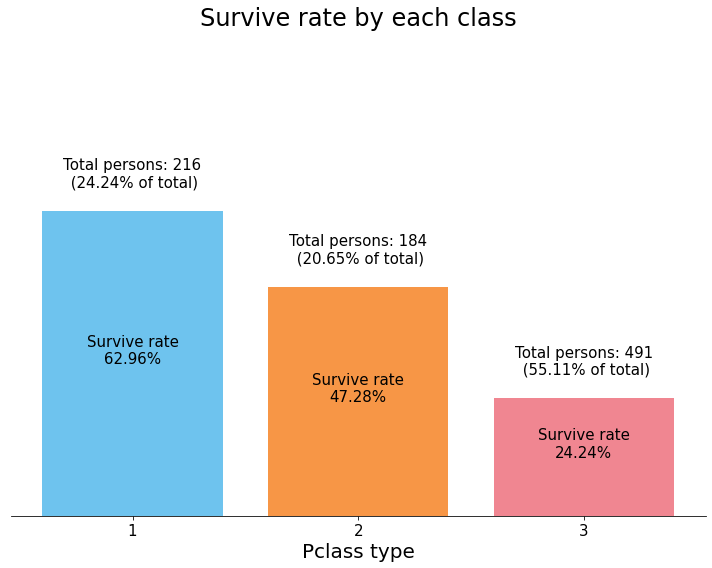

In [11]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

ax.set_ylim(0, 1)

pclass_gb = X_train_eda.groupby("Pclass")["Survived"].agg([np.mean, len]).reset_index()

x = pclass_gb["Pclass"].values
height = pclass_gb["mean"].values
nr_persons = pclass_gb["len"].values
nr_persons_pct = nr_persons/sum(nr_persons)
colors = ["#6EC3EE", "#F79646", "#F08691"]

ax.bar(x = x, height = height, color = colors)

fontdict = {'horizontalalignment': 'center', "fontsize":"15"}

for x_, height_, persons_, persons_pct_ in zip(x, height, nr_persons, nr_persons_pct):
    text_ = f"Total persons: {persons_}\n ({round(persons_pct_*100, 2)}% of total)"
    ax.text(x_, height_ + .05, s = text_, fontdict = fontdict)
    
    text_survive_rate_ = "Survive rate\n" + str(round(height_*100, 2)) + "%"
    ax.text(x_, height_*.5, s = text_survive_rate_, fontdict = fontdict)

xtick_location = ax.get_xticks()
ax.set_xticks([1, 2, 3])
ax.set_yticks([])

ax.set_xlabel("Pclass type", size = 20)

ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 15)

# remove the spines
ax.spines["top"].set_color("None")
ax.spines["left"].set_color("None")
ax.spines["right"].set_color("None")

ax.set_title("Survive rate by each class", size = 24)
fig.tight_layout()

Now this get's very interesting. If we look into Pclass and sex, we see that **Femmales in Pclass 1 had a survive rate of almost 97%**, **Survive rate for Females in PClass 2 had also a very high survive rate of 92%**, however **Women with Pclass 3 ticket had only a survive rate of 50%**.
Another very interesting insight is that **Male with Pclass 3 ticket, accounted for almost 40% of all passangers on Titanic, but their survive rate was of only 13%, which is similar to the ones from Pclass 2, but almos 3 lower that man on PClass 1.**

**For tree based models, doing variables like Female 1, Male 1 ... (mixing Sex and Pclass) can be very helpful to separate the dataset and most likely will perform very well.**

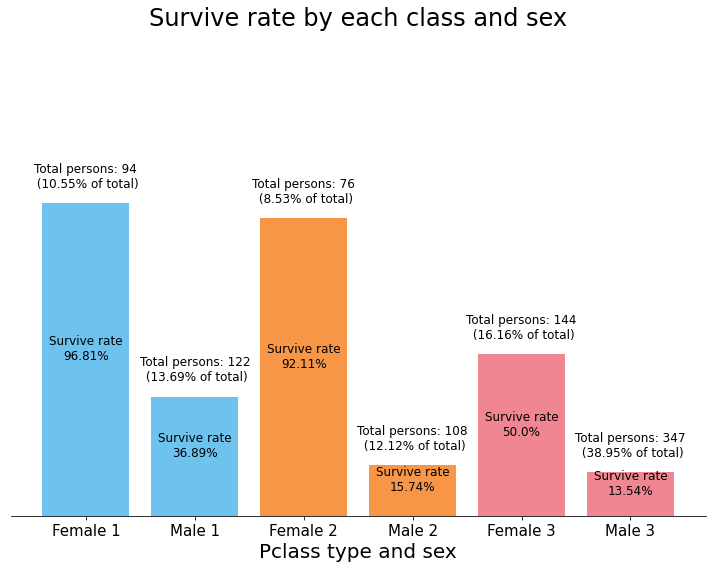

In [12]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

ax.set_ylim(0, 1.5)

pclass_gb = X_train_eda.groupby(["Pclass", "Sex"])["Survived"].agg([np.mean, len]).reset_index()
pclass_gb["PclassSex"] = pclass_gb.apply(lambda row: str.title(row["Sex"]) + " " + str(row["Pclass"]), axis = 1)

x = pclass_gb["PclassSex"].values
height = pclass_gb["mean"].values
nr_persons = pclass_gb["len"].values
nr_persons_pct = nr_persons/sum(nr_persons)
colors = ["#6EC3EE", "#6EC3EE", "#F79646", "#F79646", "#F08691", "#F08691"]

ax.bar(x = x, height = height, color = colors)

fontdict = {'horizontalalignment': 'center', "fontsize":"12"}

for x_, height_, persons_, persons_pct_ in zip(x, height, nr_persons, nr_persons_pct):
    text_ = f"Total persons: {persons_}\n ({round(persons_pct_*100, 2)}% of total)"
    ax.text(x_, height_ + .05, s = text_, fontdict = fontdict)
    
    text_survive_rate_ = "Survive rate\n" + str(round(height_*100, 2)) + "%"
    ax.text(x_, height_*.5, s = text_survive_rate_, fontdict = fontdict)

ax.set_yticks([])

ax.set_xlabel("Pclass type and sex", size = 20)

ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 15)

# remove the spines
ax.spines["top"].set_color("None")
ax.spines["left"].set_color("None")
ax.spines["right"].set_color("None")

ax.set_title("Survive rate by each class and sex", size = 24)
fig.tight_layout()

Okay, so the following plot is very interesting. If we create different **partitions by age** and look at a heatmap of mean survive rate by **Pclass and Sex combination.** We can see that If you where a **female in Class 1 and had a age more than 10, you survive rate is almost 100%.**
Something similar we can see if you are Female in Pclass 2. **The survive rate drops a lot when you are in Pclass 3 and less than 60 years.**

For Man we can see a different story. **Te survive rate is much higher in Pclass 1.**

It is very interesting to note that we have a huge portion of all passangers concentrated in **Males Pclass 3 (22%) but the survive rate is 0.13.**

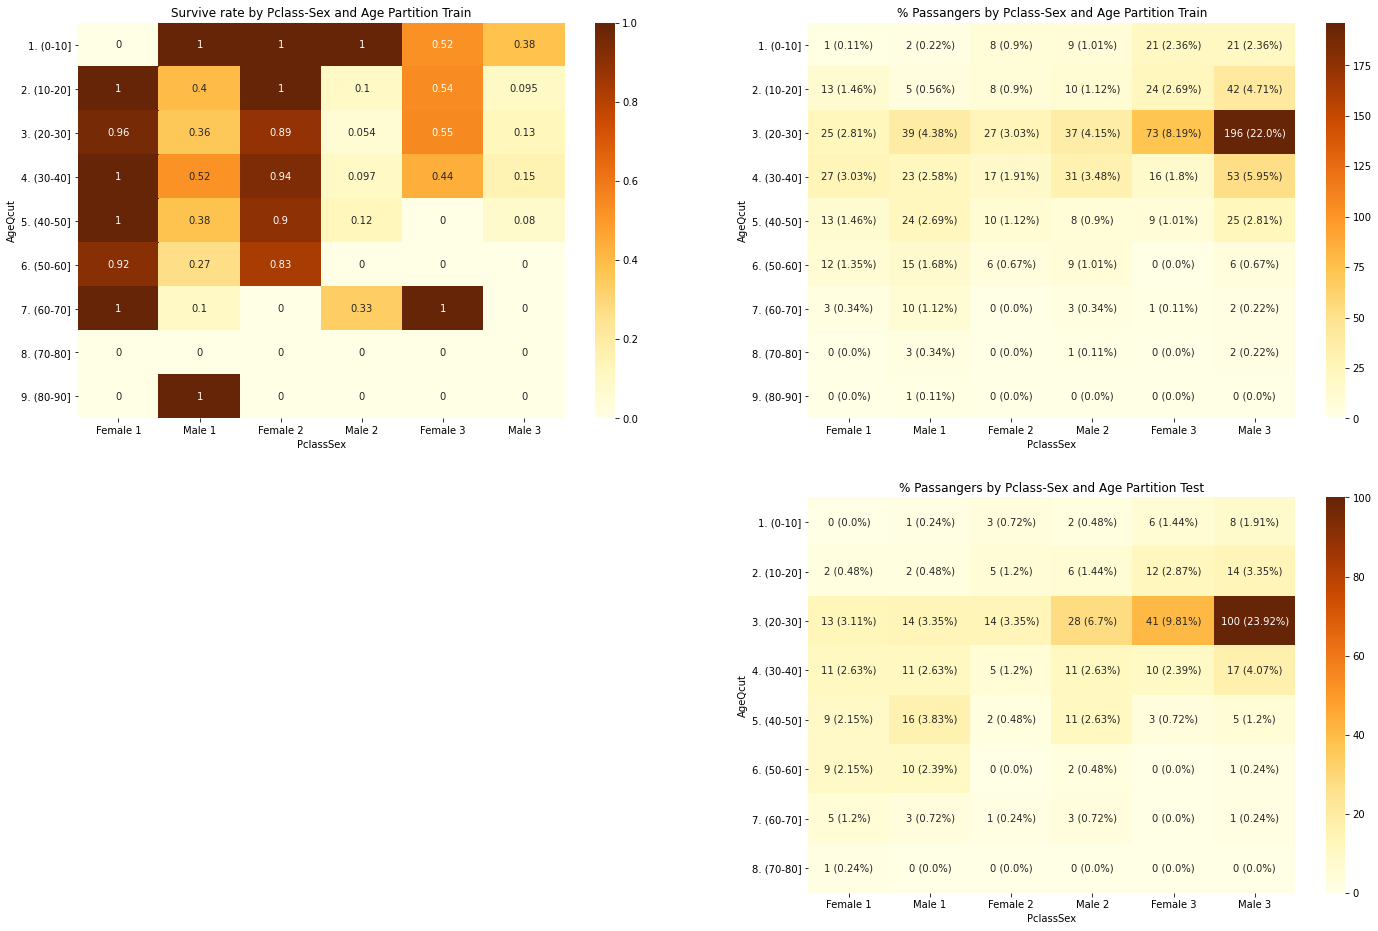

In [13]:
def create_partition(row):
    '''
    Creates different partitions in our dataframe based on the age.
    '''
    age = row["Age"]

    if 0 <= age < 10:
        return "1. (0-10]"

    elif 10 <= age < 20:
        return "2. (10-20]"

    elif 20 <= age < 30:
        return "3. (20-30]"
    
    elif 30 <= age < 40:
        return "4. (30-40]"
    
    elif 40 <= age < 50:
        return "5. (40-50]"
    
    elif 50 <= age < 60:
        return "6. (50-60]"
    
    elif 60 <= age < 70:
        return "7. (60-70]"
    
    elif 70 <= age < 80:
        return "8. (70-80]"
    
    elif 80 <= age < 90:
        return "9. (80-90]"
    
    elif age >= 90:
        return "10. [90"
        
    else:
        return "NaN"

def create_new_annotations(X):
    '''
    Creates new annotations for our heamap.
    '''
    ll = []
    for list_ in X.values:
        l = []
        for value in list_:
            new_value = str(int(value)) + " (" + str(round((value/X.sum().sum())*100, 2)) + "%)"
            l.append(new_value)
        ll.append(l)
    return ll

# ------------------------------------------------------------------------------
# prepare data for plotting
MARGINS = False
CMAP = "YlOrBr"

if MARGINS:
    lc = ["Female 1", "Male 1", "Female 2", "Male 2", "Female 3", "Male 3", "All"]
else:
    lc = ["Female 1", "Male 1", "Female 2", "Male 2", "Female 3", "Male 3"]
    
imputer = SimpleImputer(strategy = "mean")
X_train_eda["Age"] = imputer.fit_transform(X_train_eda["Age"].values.reshape(-1, 1))
X_test_eda["Age"] = imputer.transform(X_test_eda["Age"].values.reshape(-1, 1))

X_train_eda["AgeQcut"] = X_train_eda.apply(create_partition, axis = 1)
X_train_eda["PclassSex"] = X_train_eda.apply(lambda row: str.title(row["Sex"]) + " " + str(row["Pclass"]), axis = 1)

X_test_eda["AgeQcut"] = X_test_eda.apply(create_partition, axis = 1)
X_test_eda["PclassSex"] = X_test_eda.apply(lambda row: str.title(row["Sex"]) + " " + str(row["Pclass"]), axis = 1)

pt_surv = X_train_eda.pivot_table(index = "AgeQcut", columns = "PclassSex", values = "Survived", aggfunc = np.mean, margins = MARGINS, fill_value = 0)
pt_surv = pt_surv[lc]

pt_len_train = X_train_eda.pivot_table(index = "AgeQcut", columns = "PclassSex", values = "Survived", aggfunc = len, margins = MARGINS, fill_value = 0)
pt_len_train = pt_len_train[lc]

pt_len_test = X_test_eda.pivot_table(index = "AgeQcut", columns = "PclassSex", values = "Age", aggfunc = len, margins = MARGINS, fill_value = 0)
pt_len_test = pt_len_test[lc]

annotatios_train = create_new_annotations(pt_len_train)
annotatios_test = create_new_annotations(pt_len_test)

# ------------------------------------------------------------------------------
# plotting part
fig = plt.figure(figsize = (24, 16))
(ax1, ax2), (ax3, ax4) = fig.subplots(2, 2)

sns.heatmap(pt_surv, ax = ax1, cmap = CMAP, annot = True)
ax1.set_title("Survive rate by Pclass-Sex and Age Partition Train")

sns.heatmap(pt_len_train, ax = ax2, cmap = CMAP, annot = annotatios_train, fmt = '')
ax2.set_title("% Passangers by Pclass-Sex and Age Partition Train");

ax3.set_xticks([])
ax3.set_yticks([])

ax3.spines["top"].set_color("None")
ax3.spines["left"].set_color("None")
ax3.spines["right"].set_color("None")
ax3.spines["bottom"].set_color("None")

sns.heatmap(pt_len_test, ax = ax4, cmap = CMAP, annot = annotatios_test, fmt = '')
ax4.set_title("% Passangers by Pclass-Sex and Age Partition Test");

We can see that the embarked port also had an impact on the overall survive rate, but most likely it has to deal with the fact that in some ports embarked more rich people and in others more poor ones. I will take a deeper look in the future kernels.

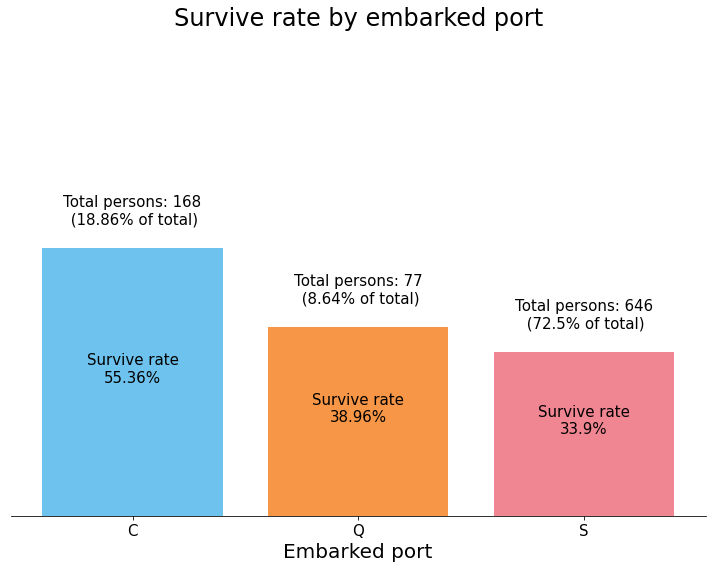

In [14]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

ax.set_ylim(0, 1)

imputer = SimpleImputer(strategy = "most_frequent")

X_train_eda["Embarked"] = imputer.fit_transform(X_train_eda["Embarked"].values.reshape(-1, 1))

pclass_gb = X_train_eda.groupby("Embarked")["Survived"].agg([np.mean, len]).reset_index()

x = pclass_gb["Embarked"].values
height = pclass_gb["mean"].values
nr_persons = pclass_gb["len"].values
nr_persons_pct = nr_persons/sum(nr_persons)
colors = ["#6EC3EE", "#F79646", "#F08691"]

ax.bar(x = x, height = height, color = colors)

fontdict = {'horizontalalignment': 'center', "fontsize":"15"}

for x_, height_, persons_, persons_pct_ in zip(x, height, nr_persons, nr_persons_pct):
    text_ = f"Total persons: {persons_}\n ({round(persons_pct_*100, 2)}% of total)"
    ax.text(x_, height_ + .05, s = text_, fontdict = fontdict)
    
    text_survive_rate_ = "Survive rate\n" + str(round(height_*100, 2)) + "%"
    ax.text(x_, height_*.5, s = text_survive_rate_, fontdict = fontdict)

xtick_location = ax.get_xticks()

ax.set_yticks([])

ax.set_xlabel("Embarked port", size = 20)

ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 15)

# remove the spines
ax.spines["top"].set_color("None")
ax.spines["left"].set_color("None")
ax.spines["right"].set_color("None")

ax.set_title("Survive rate by embarked port", size = 24)
fig.tight_layout()

Let's crunch a little bit the **Names** column and try to extract some useful features.

In [15]:
title_extractor = TitleExtractor(cleaning_dict = cleaning_dict)
X_train_eda = title_extractor.fit_transform(X_train_eda)
vc_train = X_train_eda["Title"].value_counts().to_frame()
vc_train["Origin"] = "train"

X_test_eda = title_extractor.fit_transform(X_test_eda)
vc_test = X_test_eda["Title"].value_counts().to_frame()
vc_test["Origin"] = "test"

vc = vc_train.append(vc_test)
vc = vc.pivot_table(index = vc.index, columns = "Origin", aggfunc = "sum", fill_value = 0)
vc.columns = ["test", "train"]
vc["Total"] = vc["test"] + vc["train"]
vc = vc[["train", "test", "Total"]]
vc.sort_values("Total", inplace = True, ascending = False)

survival_rate = X_train_eda[["Title", "Survived"]].pivot_table(index = "Title", aggfunc = np.mean).rename(columns = {"Survived":"Survival_rate_train"})
survival_rate["Survival_rate_train"] = survival_rate["Survival_rate_train"].apply(lambda rate: round(rate * 100, 4))
vc = pd.concat([vc, survival_rate], axis = 1)
vc

,train,test,Total,Survival_rate_train
Mr,518,240,758,15.6371
Miss,185,80,265,70.2703
Mrs,127,72,199,79.5276
Master,40,21,61,57.5000
Other,21,5,26,33.3333


Now let's explore the **Ticket** column and try to get some insights from it.

In [16]:
family_tickets = X_train_eda["Ticket"].value_counts().to_frame().reset_index()
family_tickets.rename(columns = {"Ticket": "FamilyMembers", "index":"Ticket"}, inplace = True)
X_train_eda = pd.merge(X_train_eda, family_tickets, left_on = "Ticket", right_on = "Ticket")
X_train_eda[X_train_eda["Ticket"] == "SC/Paris 2123"]
# X_train_eda[(X_train_eda["FamilyMembers"] > 1) & (X_train_eda["Pclass"] < 3)]

pivot_family_members = X_train_eda.pivot_table(index = "FamilyMembers", columns = "Pclass", values = "Survived", aggfunc = np.mean, fill_value = 0)
pivot_family_members.applymap(lambda number: round(number * 100, 3))

Pclass,1,2,3
FamilyMembers,,,
1,47.423,42.056,20.991
2,73.611,56.250,41.176
3,85.185,62.500,50.000
4,70.000,0.000,33.333
5,0.000,0.000,0.000
6,0.000,0.000,0.000
7,0.000,0.000,23.810


In [17]:
ticket_extractor = TicketExtractor()
ticket_extractor.fit_transform(X_train_eda[["Ticket", "Pclass"]])

X_ = ticket_extractor.transform(X_test_eda)
multiple_tickets = X_["Ticket"].value_counts()[X_["Ticket"].value_counts() > 1].index
X_[(X_["Ticket"].isin(multiple_tickets)) & (X_["FamilyMembers"].isnull())].sort_values("Ticket")

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeQcut,PclassSex,NameSplitted,Title,FamilyMembers
PassengerId,,,,,,,,,,,,,,,


The last column to analyze will be the **Cabin** column. Let's see what we can get from it

In [18]:
X_train_eda[~X_train_eda["Cabin"].isnull()]["Pclass"].value_counts()

1    176
2     16
3     12
Name: Pclass, dtype: int64

In [19]:
def create_combined_annotations(X_len, X_values):
    '''
    Creates combined annotations for our heamap from 2 different sourcers.
    '''
    ll = []
    for lens_, values_ in zip(X_len.values, X_values.values):
        l = []
        for len_, value_ in zip(lens_, values_):
            new_annotatios = str(int(len_)) + " (" + str(round((len_/X_len.sum().sum())*100, 2)) + "% of total)\nSurvive rate: " + str(round(value_ * 100, 2)) + "%"
            l.append(new_annotatios)
        ll.append(l)
    return ll

In [20]:
# get the multiple cabins
multiple_cabins = X_train_eda["Cabin"].value_counts()[X_train_eda["Cabin"].value_counts() > 1].index

# calculate the number of persons and survive rate by Pclass and Sex for all passangers
sr_pclass_sex_total = X_train_eda.pivot_table(index = "Pclass", columns = "Sex", values = "Survived", aggfunc = np.mean)
sr_pclass_sex_len = X_train_eda.pivot_table(index = "Pclass", columns = "Sex", values = "Survived", aggfunc = len)

# calculate the number of persons and survive rate by Pclass and Sex for passangers that traveled in a multiple cabin (more than 1 person)
sr_pclass_sex_mc = X_train_eda[X_train_eda["Cabin"].isin(multiple_cabins)].pivot_table(index = "Pclass", columns = "Sex", values = "Survived", aggfunc = np.mean)
sr_pclass_sex_mc_len = X_train_eda[X_train_eda["Cabin"].isin(multiple_cabins)].pivot_table(index = "Pclass", columns = "Sex", values = "Survived", aggfunc = len)

# calculate the number of persons and survive rate by Pclass and Sex for passangers that traveled in a individual cabin
sr_pclass_sex_uc = X_train_eda[~X_train_eda["Cabin"].isin(multiple_cabins)].pivot_table(index = "Pclass", columns = "Sex", values = "Survived", aggfunc = np.mean)
sr_pclass_sex_uc_len = X_train_eda[~X_train_eda["Cabin"].isin(multiple_cabins)].pivot_table(index = "Pclass", columns = "Sex", values = "Survived", aggfunc = len)

# create new annotations for our heatmap
total_annotations = create_combined_annotations(sr_pclass_sex_len, sr_pclass_sex_total)
mc_annotations = create_combined_annotations(sr_pclass_sex_mc_len, sr_pclass_sex_mc)
uc_annotations = create_combined_annotations(sr_pclass_sex_uc_len, sr_pclass_sex_uc)

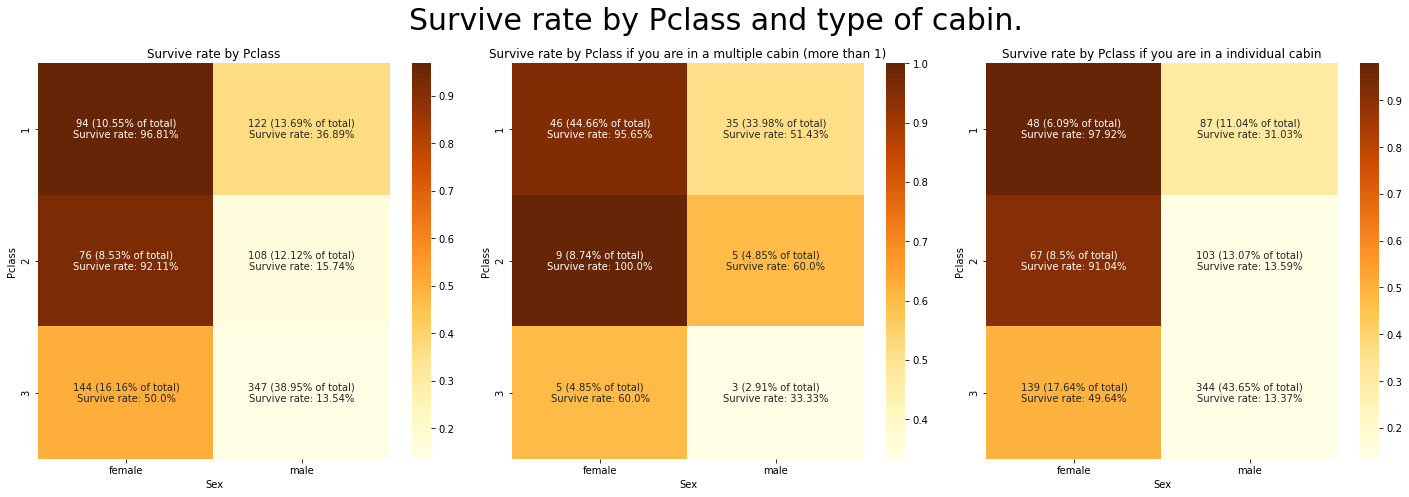

In [21]:
fig = plt.figure(figsize = (20, 7))
ax1, ax2, ax3 = fig.subplots(1, 3)

sns.heatmap(sr_pclass_sex_total, ax = ax1, cmap = CMAP, annot = total_annotations, fmt = '')
sns.heatmap(sr_pclass_sex_mc, ax = ax2, cmap = CMAP, annot = mc_annotations, fmt = '')
sns.heatmap(sr_pclass_sex_uc, ax = ax3, cmap = CMAP, annot = uc_annotations, fmt = '')

ax1.set_title("Survive rate by Pclass")
ax2.set_title("Survive rate by Pclass if you are in a multiple cabin (more than 1)")
ax3.set_title("Survive rate by Pclass if you are in a individual cabin")
fig.suptitle("Survive rate by Pclass and type of cabin.", fontsize = 30)
fig.tight_layout();

In [22]:
X_train_eda, X_test_eda = data_loader_eda.load_data()

X_train_ = X_train_eda[["Name", "Sex", "Age", "Survived", "Pclass", "Ticket"]]
X_train_["TrainTest"] = "Train"

X_test_ = X_test_eda[["Name", "Sex", "Age", "Pclass", "Ticket"]]
X_test_["TrainTest"] = "Test"

X_ = pd.concat([X_train_, X_test_], axis = 0)

class FamilyExtractor(BaseEstimator, TransformerMixin):
    '''
    This class extracts the family members groups and works with sklearn pipelines.
    '''
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X_transformed = X.copy(deep = True)
        X_transformed["FamilyName"] = X_transformed["Name"].apply(lambda full_name: full_name.split(", ")[0])
        X_transformed["FamilyNameTicket"] = X_transformed["FamilyName"] + X_transformed["Ticket"]
        
        return X_transformed
    
X_ = FamilyExtractor().fit_transform(X_)
pt_df_ = X_.pivot_table(index = "FamilyName", columns = "TrainTest", values = "Name", aggfunc = len, fill_value = 0, margins = True)
pt_df_.sort_values("All", ascending = False, inplace = True)
pt_df_short_ = pt_df_[pt_df_["All"] > 1]
pt_df_short_.head(15)

TrainTest,Test,Train,All
FamilyName,,,
All,418,891,1309
Andersson,2,9,11
Sage,4,7,11
Goodwin,2,6,8
Asplund,4,4,8
Davies,4,3,7
Panula,0,6,6
Johnson,0,6,6
Rice,1,5,6


In [23]:
FAMILY_NAME = "Andersson"
X_[(X_["FamilyName"] == FAMILY_NAME)].groupby(["FamilyNameTicket"])["Survived"].mean()
X_[(X_["FamilyName"] == FAMILY_NAME)]

,Name,Sex,Age,Survived,Pclass,Ticket,TrainTest,FamilyName,FamilyNameTicket
PassengerId,,,,,,,,,
542,"Andersson, Miss. Ingeborg Constanzia",female,9.0,0.0,3,347082,Train,Andersson,Andersson347082
814,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,0.0,3,347082,Train,Andersson,Andersson347082
543,"Andersson, Miss. Sigrid Elisabeth",female,11.0,0.0,3,347082,Train,Andersson,Andersson347082
69,"Andersson, Miss. Erna Alexandra",female,17.0,1.0,3,3101281,Train,Andersson,Andersson3101281
120,"Andersson, Miss. Ellis Anna Maria",female,2.0,0.0,3,347082,Train,Andersson,Andersson347082
611,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,0.0,3,347082,Train,Andersson,Andersson347082
147,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,1.0,3,350043,Train,Andersson,Andersson350043
851,"Andersson, Master. Sigvard Harald Elias",male,4.0,0.0,3,347082,Train,Andersson,Andersson347082
14,"Andersson, Mr. Anders Johan",male,39.0,0.0,3,347082,Train,Andersson,Andersson347082


<a id = "fe"></a>
# Feature engineering
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [24]:
# data loading
X_train, X_test = data_loader.load_data()
y = X_train["Survived"]
X_train.drop("Survived", inplace = True, axis = 1)

# separate columns by type and assert all columns are selected
numeric_columns = X_train.select_dtypes(include = np.number).columns.tolist()
object_columns = X_train.select_dtypes(exclude = np.number).columns.tolist()
assert (len(numeric_columns) + len(object_columns)) == X_train.shape[1], "You have missed some columns"

# Pipeline building

# define model for full pipeline
model = LogisticRegression()
model_name = str(model).split("(")[0]


# imputation pipeline
impute_ct = ColumnTransformer(transformers = [
    ("numeric_impute", SimpleImputer(strategy = "mean"), numeric_columns),
    ("categorical_impute", SimpleImputer(strategy = "most_frequent"), object_columns)
], remainder = "drop", n_jobs = -1)

impute_pipeline = Pipeline(steps = [
    ("impute_ct", impute_ct),
    ("numpy_to_dataframe", NumpyToDataFrame(columns = numeric_columns + object_columns))
])

# encoder = OneHotEncoder(handle_unknown = "ignore")
encoder = OrdinalEncoder()

# ohe columns transformation
encoding_columns = [
    "Sex", 
    "Embarked", 
    "AgeQcut", 
    "PclassSex",
    "Title"
]
encoding_pipeline = ColumnTransformer(transformers = [
    ("encoder", encoder, encoding_columns)
], remainder = "passthrough")

columns_to_drop = [
    "Name",
    "NameSplitted",
    "Ticket",
    "Cabin"
]

columns_to_scale = [
    "Age", 
    "Fare"
]

# scaler pipeline
scale_pipe = ColumnTransformer(transformers = [
    ("scaler", StandardScaler(), columns_to_scale)
])

# feature generator pipeline
fe_pipeline = Pipeline(steps = [
    ("feature_generator", FeatureGenerator()),
    ("ticket_extraction", TicketExtractor()),
    # ("scale_pipe", scale_pipe),
    ("title_extraction", TitleExtractor(cleaning_dict = cleaning_dict)),
    ("column_dropper", ColumnDropper(columns_to_drop = columns_to_drop)),
    ("encoding_pipeline", encoding_pipeline)
])

# imputation and fe_pipeline
imp_fe_pipeline = Pipeline(steps = [
    ("impute_pipeline", impute_pipeline),
    ("fe_pipeline", fe_pipeline)
])

full_pipeline = Pipeline(steps = [
    ("imp_fe_pipeline", imp_fe_pipeline),
    ("model", model)
])

X_transformed = imp_fe_pipeline.fit_transform(X_train)

NameError: name 'data_loader' is not defined

<a id = "model_training"></a>
# KFold model training
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [25]:
'''
# grid search
if model_name == "RandomForestClassifier":
    param_grid = {
        "model__n_estimators": [100, 200, 300],
        "model__criterion": ['gini', "entropy"],
        "model__max_depth": [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    }
    
elif model_name == "LogisticRegression":
    param_grid = {
        'model__C': np.logspace(-5, 5, 5),
        'model__penalty': ["l1", "l2"],
        'model__warm_start': [True, False]        
    }


grid = GridSearchCV(
    estimator = clone(model), 
    param_grid = param_grid, 
    scoring = "accuracy",
    refit = True,
    n_jobs = -1)

grid.fit(X_transformed, y)

grid.best_estimator_["model"]
'''

'\n# grid search\nif model_name == "RandomForestClassifier":\n    param_grid = {\n        "model__n_estimators": [100, 200, 300],\n        "model__criterion": [\'gini\', "entropy"],\n        "model__max_depth": [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]\n    }\n    \nelif model_name == "LogisticRegression":\n    param_grid = {\n        \'model__C\': np.logspace(-5, 5, 5),\n        \'model__penalty\': ["l1", "l2"],\n        \'model__warm_start\': [True, False]        \n    }\n\n\ngrid = GridSearchCV(\n    estimator = clone(model), \n    param_grid = param_grid, \n    scoring = "accuracy",\n    refit = True,\n    n_jobs = -1)\n\ngrid.fit(X_transformed, y)\n\ngrid.best_estimator_["model"]\n'

In [26]:
'''
X_train_transformed = full_pipeline.fit_transform(X_train)
    
cv_scores = []

kfold = KFold(n_splits = FOLDS)

for train_index, valida_index in kfold.split(X_train_transformed):
    
    model_ = clone(model)
    
    X_train_, y_train_ = X_train_transformed[train_index], y.values[train_index]
    X_val_, y_val = X_train_transformed[valida_index], y.values[valida_index]
    
    model_.fit(X_train_, y_train_)
    kfold_pred = model_.predict(X_val_)
    cv_scores.append(accuracy_score(y_val, kfold_pred))
    
mean_cv_score = round(np.mean(cv_scores), 5)

valida_score = "-"
print("KFold score is {}".format(cv_scores))
print("|Version |{}|{}|{}|{}|{}||".format(mean_cv_score, valida_score, FOLDS, "-", model_name))
'''

'\nX_train_transformed = full_pipeline.fit_transform(X_train)\n    \ncv_scores = []\n\nkfold = KFold(n_splits = FOLDS)\n\nfor train_index, valida_index in kfold.split(X_train_transformed):\n    \n    model_ = clone(model)\n    \n    X_train_, y_train_ = X_train_transformed[train_index], y.values[train_index]\n    X_val_, y_val = X_train_transformed[valida_index], y.values[valida_index]\n    \n    model_.fit(X_train_, y_train_)\n    kfold_pred = model_.predict(X_val_)\n    cv_scores.append(accuracy_score(y_val, kfold_pred))\n    \nmean_cv_score = round(np.mean(cv_scores), 5)\n\nvalida_score = "-"\nprint("KFold score is {}".format(cv_scores))\nprint("|Version |{}|{}|{}|{}|{}||".format(mean_cv_score, valida_score, FOLDS, "-", model_name))\n'

In [27]:
X_transformed = imp_fe_pipeline.fit_transform(X_train)

cv_scores = cross_val_score(
    estimator = clone(model),
    X = X_transformed,
    y = y,
    cv = FOLDS,
    n_jobs = -1,
    scoring = "accuracy"
)

mean_cv_score = round(np.mean(cv_scores), 5)

valida_score = "-"
print("KFold score is {}".format(cv_scores))
print("|Version |{}|{}|{}|{}|{}||".format(mean_cv_score, valida_score, FOLDS, "-", model_name))

cv_predictions = cross_val_predict(
    estimator = clone(model),
    X = X_transformed,
    y = y,
    cv = FOLDS,
    method = "predict",
    n_jobs = -1
)

cm = confusion_matrix(y, cv_predictions)
print()
print("Confusion Matrix")
print(cm)

NameError: name 'imp_fe_pipeline' is not defined

In [28]:
'''
# full pipe with title
Confusion Matrix
[[488  61]
 [110 232]]

# pipe without title
Confusion Matrix
[[495  54]
 [125 217]]
 
 # OE and RandomForest
 Confusion Matrix
[[478  71]
 [ 92 250]]
'''

'\n# full pipe with title\nConfusion Matrix\n[[488  61]\n [110 232]]\n\n# pipe without title\nConfusion Matrix\n[[495  54]\n [125 217]]\n \n # OE and RandomForest\n Confusion Matrix\n[[478  71]\n [ 92 250]]\n'

<a id = "test_data_prep_pred"></a>
# Test data preparation and predict
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [29]:
full_pipeline.fit(X_train, y.values)
y_test_pred = full_pipeline.predict(X_test)

NameError: name 'full_pipeline' is not defined

<a id = "kaggle_sub"></a>
# Kaggle submission
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [30]:
submission = pd.DataFrame()

submission["PassengerId"] = X_test.index
submission["Survived"] = y_test_pred
submission.set_index("PassengerId", inplace = True)
submission.to_csv("submission.csv")

NameError: name 'X_test' is not defined

<a id = "cv_vs_kaggle_lb"></a>
# CV vs Kaggle LB
[Go back to the table of contets](#toc)

Some cells might be hidden, use the ***unhide button*** to see all the code.

In [31]:
valida_score = "-"
print("|Version |{}|{}|{}|{}|{}|{}|Comments|".format(mean_cv_score, cv_scores,valida_score, FOLDS, "-", model_name))

NameError: name 'mean_cv_score' is not defined

|Version Control|Accuracy Train CV|CV_scores|Accuracy Test|CV|Kaggle Score|Model|Comments|
|---|---|---|---|---|---|---|---|
|Version 1|0.7879||-|4|0.77272|LogisticRegression|A basic pipeline and eda|
|Version 5|0.8126||-|4|0.76555|RandomForestClassifier|Clean pipeline for imputation, fe and predict. Have a higher score with version 4, but it uses grid|
|Version 6|0.8014||-|4|0.71052|LogisticRegression||
|Version 7|0.80472||-|4|0.76315|RandomForestClassifier||
|Version 8|0.8137||-|4|0.75119|RandomForestClassifier||
|Version 9|0.79128||-|4|0.76315|LogisticRegression||
|Version 10|0.80923|[0.79372197 0.8206278  0.78923767 0.83333333]|-|4|0.77033|LogisticRegression||
|Version 11|0.82375|[0.82511211 0.82959641 0.85650224 0.78378378]|-|4|0.77272|LogisticRegression||
|Version 12|0.82266|[0.8206278  0.84753363 0.81165919 0.81081081]|-|4|0.77511|LogisticRegression|Added Title and Ticket Extraction|
|Version 13|0.82042|[0.84304933 0.84304933 0.78026906 0.81531532]|-|4|0.74401|XGBClassifier|Comments|

# The end

[Go back to the table of contets](#toc)